# A4 Part 1: MuJoCo CartPole - Reinforcement Learning Implementation

In this section, you are going to set up the MuJoCo environment to do physics-based reinforcement learning. Make sure you have the required packages installed as listed in the `environment.yml` file.

## MuJoCo Installation

MuJoCo now is open-sourced project and can be installed via the pip package. You can install it by running the following command:

```bash
pip install mujoco
```

## `dm_control` (deep-mind control) Installation

`dm_control` is a package that provides a suite of continuous control tasks. You can install it by running the following command:

```bash
pip install dm_control
```

Make sure you have `cmake` installed on your system.

## `ffmpeg` Installation

`ffmpeg` is a package that is used to render the video of the environment. You can install it by running the following command:

If you are on linux, you can install it by running the following command:

```bash
sudo apt-get install ffmpeg 
```

If you are on macOS, you can install it by running the following command, make sure you have `brew` installed:

```bash
brew install ffmpeg
```

If you are on Windows, you can install it by running the following command:

```bash
conda install -c conda-forge ffmpeg
```

### `mujoco_tutorial.ipynb`

Before starting this part of the assignment, please make sure you have completed the `mujoco_tutorial.ipynb` notebook. This notebook will help you understand the basics of the MuJoCo environment and how to interact with it.

In [1]:
%load_ext autoreload
%autoreload 2

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from src.utils import display_video


## Cartpole Balance & Swingup Tasks

In the following section, we will look at the Cartpole Balance and Swingup tasks. The Cartpole Balance task is a classic control problem where the goal is to balance a pole on a cart. The Cartpole Swingup task is a more challenging version of the Cartpole Balance task where the goal is to swing the pole up and balance it on the cart. This will be broken into two parts.

1. **Part 1:** Implement TD-Learning for both Cartpole Balance Task and Cartpole Swingup Task.
   - Define the TD-Learning algorithm function.
   - Initialize necessary parameters such as learning rate and discount factor.
   - Implement the training loop to update values using the TD-Learning algorithm.

2. **Part 2:** Explore different quantization hyperparameters to optimize the performance of the TD-Learning algorithm.
    - Implement the training loop to update values using the TD-Learning algorithm.
    - Explore different quantization hyperparameters to optimize the performance of the TD-Learning algorithm.
    -Leaderboard Submission
        - Submit your best `q_table` alongside with your hyperparameter of the quantization to gradescope, we will evaluate your submission based on the performance of the `q_table` and rank your performance. The top 10 % of the submission will receive 1pts extra credit on this assignment.
    

## Part 1: Implement TD-Learning for Cartpole Balance Task

In this sub-part, you will implement the TD-Learning algorithm for the Cartpole Balance task. The Cartpole Balance task is a classic control problem where the goal is to balance a pole on a cart. The state space consists of the cart's position, the cart's velocity, the pole's angle, and the pole's angular velocity.

### Take a look at the environment

The following cell runs the Cartpole Balance task for a single episode and renders the environment. Below, you will implement the TD-Learning algorithm to interact with this environment and learn a policy for balancing the pole.

In [2]:
import numpy as np
from dm_control import suite    
import copy

In [3]:
# Random policy for cartpole balance task

# Load the environment
random_state = np.random.RandomState(42)
env = suite.load("cartpole", "balance", task_kwargs={"random": random_state})

# Simulate episode with random actions
duration = 5  # Seconds
frames = []
ticks = []
rewards_balance = []
observations = []

spec = env.action_spec()
time_step = env.reset()

# Simulate the environment (environment loop)
while env.physics.data.time < duration:
    action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
    time_step = env.step(action)
    camera0 = env.physics.render(camera_id=0, height=400, width=400)
    camera1 = env.physics.render(camera_id=1, height=400, width=400)
    frames.append(np.hstack((camera0, camera1)))
    rewards_balance.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)


html_video = display_video(frames, framerate=1.0 / env.control_timestep())

html_video

In [4]:
# random policy for cartpole swingup task

# Load the environment
random_state = np.random.RandomState(42)
env = suite.load("cartpole", "swingup", task_kwargs={"random": random_state})

# Simulate episode with random actions
duration = 5  # Seconds
frames = []
ticks = []
rewards_balance = []
observations = []

spec = env.action_spec()
time_step = env.reset()

# Simulate the environment (environment loop)
while env.physics.data.time < duration:
    action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
    time_step = env.step(action)
    camera0 = env.physics.render(camera_id=0, height=400, width=400)
    camera1 = env.physics.render(camera_id=1, height=400, width=400)
    frames.append(np.hstack((camera0, camera1)))
    rewards_balance.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)


html_video = display_video(frames, framerate=1.0 / env.control_timestep())

html_video

You should see the cartpole environment rendering, but with random actions. The pole should fall over quickly. This is not very intelligent right? Luckily, we can do a lot better with reinforcement learning! One of the simplest algorithms is TD-Learning, which we will implement in this sub-part. Before doing that, let's do more analysis on the episode we just simulated.

Since the whole environment is simulated in MuJoCo, this means that we get access to every single state of the environment, including the observations and the rewards throughout the episode. The following cell will plot the observations and rewards throughout the episode. Later, you will use this graph to understand the MDP of the Cartpole Balance task.

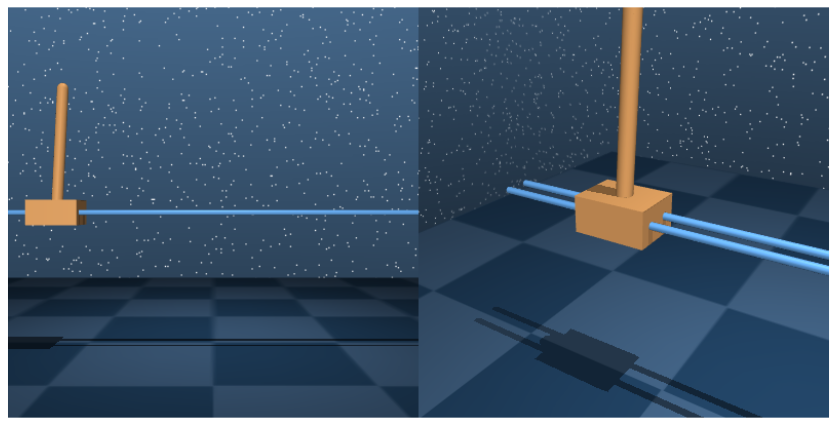

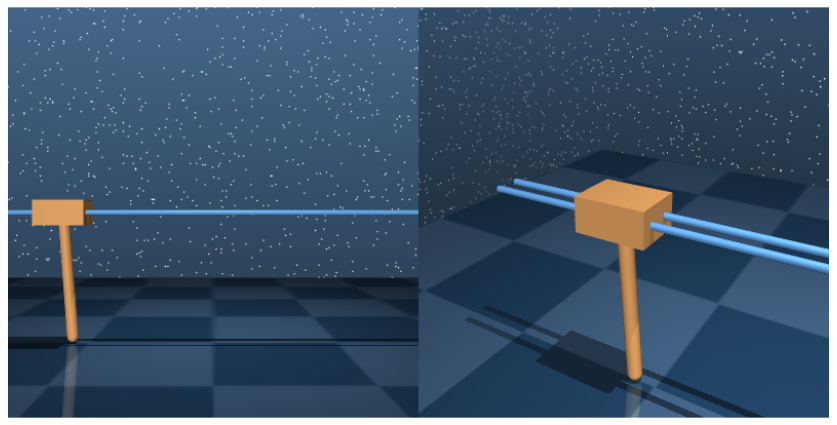

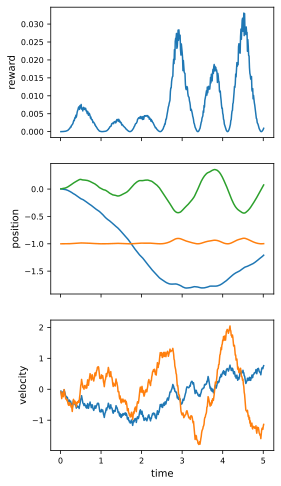

In [5]:
%matplotlib inline

def plot_episode_stats(observations: list, rewards: list, ticks: list):
    """
    Plot the episode statistics based on the observations

    Args:
        observations (list): List of observations from the environment
    """
    num_sensors = len(observations[0])

    _, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
    ax[0].plot(ticks, rewards)
    ax[0].set_ylabel("reward")
    ax[-1].set_xlabel("time")

    for i, key in enumerate(observations[0]):
        data = np.asarray([observations[j][key] for j in range(len(observations))])
        ax[i + 1].plot(ticks, data, label=key)
        ax[i + 1].set_ylabel(key)
    plt.show()

plot_episode_stats(observations, rewards_balance, ticks)

## Task 1: TD Learning for Cartpole with quantization of state space and action space

In this task, we will implement TD Learning for the Cartpole environment. One way to handle continuous state and action spaces is by discretizing them into bins. This process, known as quantization, allows us to apply discrete reinforcement learning algorithms to continuous tasks. We will define the state and action bins, initialize the Q-table, train the agent using the TD Learning algorithm, and visualize the learning progress by plotting the total rewards obtained in each episode.

### Define the state and action bins

Since the cartpole environment receives a continuous state space, we need to discretize it into bins to make the state space and action space discrete. We will define the state and action bins for the Cartpole environment. The state bins will be used to discretize the continuous state space, while the action bins will be used to discretize the continuous action space. By doing this, we can construct the Q-table for the task.

Before doing that, let's take a look at the state and action spaces of the Cartpole environment.

In [6]:
# take a look at the action spec
spec = env.action_spec()
spec

BoundedArray(shape=(1,), dtype=dtype('float64'), name=None, minimum=[-1.], maximum=[1.])

In [7]:
# take a look at the first observation, action, and reward
observations[-1], action[0], rewards_balance[0]

(OrderedDict([('position', array([-1.20818963, -0.99716606,  0.07523192])),
              ('velocity', array([ 0.76152243, -1.13725599]))]),
 np.float64(0.36946234510775855),
 np.float64(6.659309269892899e-07))

For the states representation, we have 5 dimensional observations, three for the position, and two for velocity. For action space, we have 1-dimensional action space, which is the force applied to the cart. Let's start to quantize (discretize) the state and action space.

For the discretization, we will define a sequences of bins for each dimension of the state and action space. We will use the `np.linspace` function to create these bins. The number of bins for each dimension is a hyperparameter that you can tune to optimize the performance of the TD Learning algorithm.

### Hyperparameter of Discretization

The following bin configs are provided as a starting point. The algorithm might learn something but the quantization is not optimal. You can change these values to optimize the performance of the TD Learning algorithm.

In [8]:
# Define custom bin configurations for each observation dimension.
# For each observation variable, specify a list of (min, max, bin_nums)
# In this example, we assume:
#   - 'position' has 3 dimensions and we use BIGGER_SIZE bins for each.
#   - 'velocity' has 2 dimensions and we use MEDIUM_SIZE bins for each.
# Define custom bin configurations for each observation dimension individually.
# You can adjust the range and bin count for each dimension as needed.
pos_bins_config = [
    (-1.0, 1.0, 2),  # Config for the first position component
    (-1.0, 1.0, 2),  # Config for the second position component
    (-2.0, 2.0, 5),  # Config for the third position component
]

vel_bins_config = [
    (-1.0, 1.0, 2),  # Config for the first velocity component
    (-10.0, 10.0, 5),  # Config for the second velocity component
]

obs_bins_config = {"position": pos_bins_config, "velocity": vel_bins_config}

# Create a list of bins arrays corresponding to each observation dimension.
state_bins = {
    key: [
        np.linspace(min_val, max_val, bin_num) for min_val, max_val, bin_num in config
    ]
    for key, config in obs_bins_config.items()
}

action_bins_config = (-1, 1, 4)

action_bins = np.linspace(*action_bins_config)

after we define the bins, we now can start to quantize the states. Implement the functions that takes the continuous state and returns the quantized state in `src/discretize.py`

In [9]:
from src.discretize import quantize_state


time_step = env.reset()
obs = time_step.observation

quantized_state = quantize_state(obs, state_bins)
print("Quantized State:", quantized_state)

Quantized State: ((np.int64(0), np.int64(0), np.int64(1)), (np.int64(0), np.int64(1)))


Nice! Now we can tackle the continuous control problem with discrete reinforcement learning algorithms. Next, based on the quantized state and action spaces, we will initialize the Q-table for the Cartpole environment.

In [10]:
from src.td import initialize_q_table

q_table_balance = initialize_q_table(state_bins, action_bins)
print("Initialized Q-Table shape:", q_table_balance.shape)

Initialized Q-Table shape: (3, 2, 4)


The Q-table shape will be dependent on how you setup the quantization. If you quantize the space with more bins, your q-table will be larger. Let's take a look at the total number of parameter in the Q-table.

In [11]:
print("Total number of Q-values:", np.prod(q_table_balance.size))

Total number of Q-values: 24


This will be important when you explore the hyperparameter of the discretization.

Next, let's implement the TD learning algorithm based on the quantization and the q-table we created.

In [16]:
from src.td import td_learning

# Define the environment and parameters
env = suite.load("cartpole", "balance")
num_episodes = 1000  # hyperparameter
alpha = 0.1  # hyperparameter
gamma = 0.99  # hyperparameter
epsilon = 0.1  # hyperparameter

# Train the agent
q_table_balance, rewards_balance = td_learning(
    env, num_episodes, alpha, gamma, epsilon, state_bins, action_bins
)

Training Episodes: 100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


after training, we can plot the reward progression of the learner as it learns to balance the pole on the cart.

**Submission:** Submit the following reward progression plot `td-balance.png` to the Gradescope

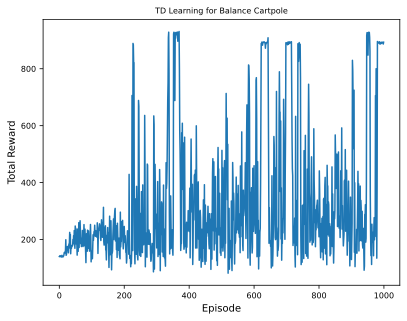

In [17]:
# Plot the rewards
# if it is weird looking, run it twice
plt.plot(rewards_balance)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("TD Learning for Balance Cartpole")
# save the figure for submission
plt.savefig("td-balance.png", dpi=200)
plt.show()

After training the agent, we should take a look at the q-table to see how the agent has learned to balance the pole on the cart. The following cell will displace the total number of elements in the q-table and the total number of non-zero elements in the q-table.

In [18]:
def inspect_q_table(q_table: np.ndarray):
    """
    Inspect the Q-table for characteristics of the learned values.

    Args:
        q_table (np.ndarray): Q-values for state-action pairs.
    """
    total_elements = np.prod(q_table.shape)
    non_zero_elements = np.sum(np.isclose(q_table, 0))
    total_non_zero_elements = total_elements - non_zero_elements

    print(f"Total number of Q-values: {total_elements}")
    print(f"Number of non-zero Q-values: {total_non_zero_elements}")
    print(
        f"Percentage of non-zero Q-values: {100 * total_non_zero_elements / total_elements:.2f}%"
    )


inspect_q_table(q_table_balance)

Total number of Q-values: 3888
Number of non-zero Q-values: 396
Percentage of non-zero Q-values: 10.19%


That is very sparse! To improve the performance of your algorithm, you should explore how to better discretize the space in order to have a better representation of the states. You will do that in the next part where you are going to optimize the performance of the agent.

In [19]:
from src.td import greedy_policy
from src.utils import run_episode

env = suite.load("cartpole", "balance")

# Define the greedy policy
greedy_policy_fn = greedy_policy(q_table_balance)

# Example usage: get the action for a given state
example_state = quantize_state(env.reset().observation, state_bins)
action = greedy_policy_fn(example_state)
print(f"Greedy action for the example state: {action}")

Greedy action for the example state: 0


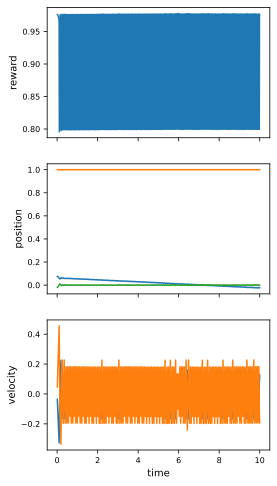

Total reward received during the episode: 886.0934708236105


In [20]:
# Run an episode using the greedy policy
total_reward, frames, stats = run_episode(
    env, greedy_policy_fn, state_bins, action_bins
)

plot_episode_stats(*stats)

# Display the video of the episode
html_video = display_video(frames, framerate=50)
print(f"Total reward received during the episode: {total_reward}")
html_video

## Sub-part 2: Train the cartpole swing up tasks

In previous section, you have trained the balance task. The swing up tasks is more difficult than the balance task since the cart needs to first swing up the pole, and then keep it balance. Let's train the swing up task with the same TD learning algorithm!

In [21]:
from src.td import td_learning

# Define the environment and parameters
env = suite.load("cartpole", "swingup")
num_episodes = 1000  # hyperparameter
alpha = 0.1  # hyperparameter
gamma = 0.99  # hyperparameter
epsilon = 0.1  # hyperparameter

# Train the agent
q_table_swingup, rewards_swingup = td_learning(
    env, num_episodes, alpha, gamma, epsilon, state_bins, action_bins
)

Training Episodes: 100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


**Submission:** Submit the following reward progression plot `td-swingup.png` to the Gradescope

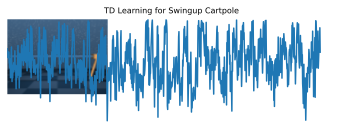

In [25]:
# Plot the rewards

### if it is weird looking, run it twice ###
plt.plot(rewards_swingup)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("TD Learning for Swingup Cartpole")

# save the figure for submission
plt.savefig("td-swingup.png", dpi=200)
plt.show()

In [23]:
inspect_q_table(q_table_swingup)

Total number of Q-values: 3888
Number of non-zero Q-values: 387
Percentage of non-zero Q-values: 9.95%


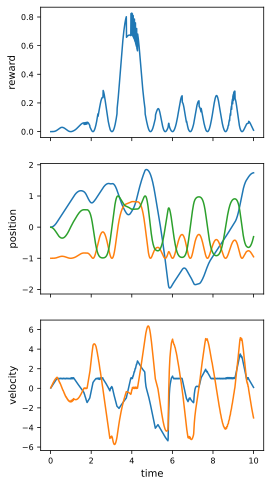

Total reward received during the episode: 139.27610756247157


In [24]:
env = suite.load("cartpole", "swingup")

# Define the greedy policy
greedy_policy_fn = greedy_policy(q_table_swingup)

# Run an episode using the greedy policy
total_reward, frames, stats = run_episode(
    env, greedy_policy_fn, state_bins, action_bins
)


plot_episode_stats(*stats)

# Display the video of the episode
html_video = display_video(frames, framerate=50)
print(f"Total reward received during the episode: {total_reward}")
html_video

### Optional: Explore Continual Learning between Tasks

In the previous section, you have trained the balance task and the swing up task separately. In this section, you can explore how to train the balance task first, and then train the swing up task on top of the balance task. This is a form of continual learning where the agent learns to balance the pole first, and then learns to swing up the pole. You can explore how to transfer the knowledge from the balance task to the swing up task to improve the performance of the agent.

One way to transfer knowledge from one task to another is to initialize the Q-table of the swing up task with the Q-table learned from the previous task of balance. You can explore how to initialize the Q-table with the Q-table learned from the balance task to improve the performance of the agent on the swing up task.

In [ ]:
# Define the environment and parameters
env = suite.load("cartpole", "swingup")
num_episodes = 1000  # hyperparameter
alpha = 0.1  # hyperparameter
gamma = 0.99  # hyperparameter
epsilon = 0.1  # hyperparameter

# Train the agent with initial knowledge from the balance task
q_table_swingup_transfer, rewards_swingup_transfer = td_learning(
    env,
    num_episodes,
    alpha,
    gamma,
    epsilon,
    state_bins,
    action_bins,
    q_table=q_table_balance,  # reusing the q_table from the balance task
)

In [ ]:
# Plot the rewards
# if it is weird looking, run it twice
plt.plot(rewards_swingup_transfer)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("TD Learning for Transfer Swingup Cartpole from Balance")

plt.savefig("td_learning_transfer_swingup_cartpole.png")
plt.show()

In [ ]:
inspect_q_table(q_table_swingup_transfer)

In [ ]:
env = suite.load("cartpole", "swingup")

# Define the greedy policy
greedy_policy_fn = greedy_policy(q_table_swingup_transfer)

# Run an episode using the greedy policy
total_reward, frames, stats = run_episode(
    env, greedy_policy_fn, state_bins, action_bins
)


plot_episode_stats(*stats)

# Display the video of the episode
html_video = display_video(frames, framerate=50)
print(f"Total reward received during the episode: {total_reward}")
html_video

# Part 2: Explore different quantization and training hyperparameters

In this part, you will explore different quantization and training hyperparameters to optimize the performance of the TD-Learning algorithm for the Cartpole Balance and Swingup tasks. You will use the training algorithm we implemented in the previous part, and explore different hyperparameters to optimize the performance of the agent.

We will benchmark the performance of the agent based on the total rewards obtained in each episode. You will explore different hyperparameters such as the number of bins for the state and action spaces, the learning rate, and the discount factor. You will train the agent with different hyperparameters and plot the total rewards obtained in each episode to analyze the performance of the agent.

For submission, you need to submit two pickle files that contain the q-table and the bins for the balance and swing-up tasks. We will evaluate your submission based on the performance of the q-table and the bins.

In [60]:
from collections import namedtuple
learning_rate_params = namedtuple("HyperparamSetup", ["env", "num_episodes", "alpha", "gamma", "epsilon", "state_bins", "action_bins"])

pos_bins_config_1 = [
    (-3.0, 3.0, 2),  # Config for the first position component
    (-3.0, 3.0, 2),  # Config for the second position component
    (-3.0, 3.0, 2),  # Config for the third position component
]

vel_bins_config_1 = [
    (-5.0, 5.0, 4),  # Config for the first velocity component
    (-5.0, 5.0, 7),  # Config for the second velocity component
]

obs_bins_config_1 = {"position": pos_bins_config, "velocity": vel_bins_config}

# Create a list of bins arrays corresponding to each observation dimension.
state_bins_1 = {
    key: [
        np.linspace(min_val, max_val, bin_num) for min_val, max_val, bin_num in config
    ]
    for key, config in obs_bins_config_1.items()
}

action_bins_config_1 = (-2, 2, 10)

action_bins_1 = np.linspace(*action_bins_config)

hyperparams_1 = learning_rate_params(env, 1500, 0.15, 0.95, 0.2, action_bins_1, state_bins_1)

q_table_1, rewards_1 = td_learning(
    env, 
    num_episodes = 1500 , 
    alpha = 0.15 ,
    gamma = 0.995 ,
    epsilon = 0.2, 
    state_bins=state_bins_1, 
    action_bins=action_bins_1
)



Training Episodes: 100%|██████████| 1500/1500 [08:02<00:00,  3.11it/s]


In [61]:

pos_bins_config_2 = [
    (-4.0, 4.0, 10),  # Config for the first position component
    (-4.0, 4.0, 10),  # Config for the second position component
    (-4.0, 4.0, 10),  # Config for the third position component
]

vel_bins_config_2 = [
    (-6.0, 6.0, 5),  # Config for the first velocity component
    (-6.0, 6.0, 8),  # Config for the second velocity component
]

obs_bins_config_2 = {"position": pos_bins_config, "velocity": vel_bins_config}

# Create a list of bins arrays corresponding to each observation dimension.
state_bins_2 = {
    key: [
        np.linspace(min_val, max_val, bin_num) for min_val, max_val, bin_num in config
    ]
    for key, config in obs_bins_config_2.items()
}

action_bins_config_2 = (-2, 2, 10)

action_bins_2 = np.linspace(*action_bins_config)

hyperparams_2 = learning_rate_params(env, 1200, 0.12, 0.90, 0.15, action_bins_2, state_bins_2)

q_table_2, rewards_2 = td_learning(
    env, 
    num_episodes = 1200, 
    alpha = 0.12 ,
    gamma = 0.90 ,
    epsilon = 0.15, 
    state_bins=state_bins_2, 
    action_bins=action_bins_2
)



Training Episodes: 100%|██████████| 1200/1200 [06:24<00:00,  3.12it/s]


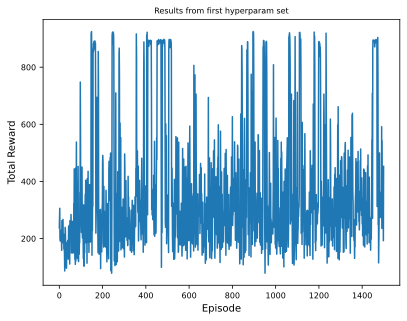

In [62]:
plt.plot(rewards_1)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Results from first hyperparam set")

plt.show()

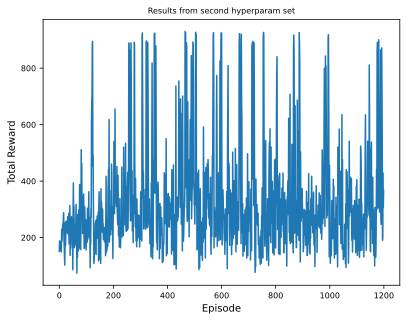

In [63]:
plt.plot(rewards_2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Results from second hyperparam set")

plt.show()

## Leaderboard Submission

Save your variable of the q-table and the bins for the balance and swing-up tasks in a pickle file in the following cell. Feel free to create as many cell as you need to save the variables. We will evaluate your submission based on the performance of the q-table and the bins.

In [64]:
import pickle


q_table_balance = q_table_1
state_bins_balance, action_bins_balance = state_bins_1, action_bins_1

with open("q_table_balance.pkl", "wb") as f:
    pickle.dump((q_table_balance, state_bins_balance, action_bins_balance), f)

q_table_swingup = q_table_2
state_bins_swingup, action_bins_swingup = state_bins_2, action_bins_2

with open("q_table_swingup.pkl", "wb") as f:
    pickle.dump((q_table_swingup, state_bins_swingup, action_bins_swingup), f)

# submit those two file to gradescope.

## Part 3: DQN for Cartpole Balance Task

In this part, you will implement the Deep Q-Network (DQN) algorithm for the Cartpole Balance task. The DQN algorithm uses a neural network to approximate the Q-function, which allows us to learn a policy for balancing the pole on the cart. You will implement the DQN algorithm, train the agent using the Cartpole Balance task, and visualize the learning progress by plotting the total rewards obtained in each episode.

In [ ]:
plt.plot(rewards)
plt.title("DQN on Cartpole Balance (MPS)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

In [ ]:
env = suite.load("cartpole", "balance")
time_step = env.reset()
frames = []
total_reward = 0

while not time_step.last():
    state = collect_state(time_step.observation)
    state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = model(state_t)
        action_idx = int(torch.argmax(q_values))
    action_val = ACTION_LIST[action_idx].reshape((1,))
    # print(action_val)
    time_step = env.step(action_val)
    total_reward += time_step.reward or 0.0

    # record frames from two cameras
    camera0 = env.physics.render(camera_id=0, height=400, width=400)
    camera1 = env.physics.render(camera_id=1, height=400, width=400)
    frames.append(np.hstack((camera0, camera1)))

html_video = display_video(frames, framerate=50)
print(f"Total reward: {total_reward}")
html_video

# Submission

Required files for submission:

1. `td-balance.png`: Reward progression plot for the Cartpole Balance task.
2. `td-swingup.png`: Reward progression plot for the Cartpole Swingup task.
3. `q_table_balance.pkl`: Pickle file containing the q-table and bins for the Cartpole Balance task.
4. `q_table_swingup.pkl`: Pickle file containing the q-table and bins for the Cartpole Swingup task.
5. `discretize.py`: Python file containing the implementation of the discretize function.
6. `td.py`: Python file containing the implementation of the TD Learning algorithm.


Submit the above files to the Gradescope. We will evaluate your submission based on the performance of the q-table and the bins. The top 10% of the submission will receive 1 point extra credit on this assignment.